#### Learning LangGraph - Essentials

In [ ]:
from langgraph.graph import StateGraph, END
from typing import Dict, TypedDict, Optional, Literal

In [2]:
class GraphState(TypedDict):
    init_input: Optional[str] = None
    first_word: Optional[str] = None
    second_word: Optional[str] = None
    final_result: Optional[str] = None

In [3]:
def input_first(state: GraphState) -> Dict[str, str]:
    print("""start input_first()""")
    init_input = state.get("init_input", "").strip()
    if init_input != "hello":
        return {"first_word": "error"}
    return {"first_word": "hello"}


def input_second(state: GraphState) -> Dict[str, str]:
    print("""start input_second()""")
    if state.get("first_word") == "error":
        {"second_word": "error"}
    return {"second_word": "world"}


def complete_word(state: GraphState) -> Dict[str, str]:
    print("""start complete_word()""")
    if state.get("first_word") == "error" or state.get("second_word") == "error":
        return {"final_result": "error"}
    return {"final_result": state["first_word"] + ", " + state["second_word"] + "!"}


def error(state: GraphState) -> Dict[str, str]:
    print("""start error()""")
    return {"final_result": "error", "first_word": "error", "second_word": "error"}


def continue_next(
    state: GraphState,
) ->  Literal["to_input_second", "to_error"]:
    print(f"continue_next: state: {state}")
    if state.get("first_word") == "hello" and state.get("second_word") == None:
        print("- continue to_input_second")
        return "to_input_second"

    if (
        state.get("first_word") == "error"
        or state.get("second_word") == "error"
        or state.get("final_result") == "error"
    ):
        print("- continue to_error")
        return "to_error" 

In [4]:
workflow = StateGraph(GraphState)

workflow.add_node("input_first", input_first)
workflow.add_node("input_second", input_second)
workflow.add_node("complete_word", complete_word)
workflow.add_node("error", error)

workflow.set_entry_point("input_first")
workflow.add_edge("input_second", "complete_word")
workflow.add_edge("complete_word", END)
workflow.add_edge("error", END)

workflow.add_conditional_edges(
    "input_first", # start node name
    continue_next, # decision of what to do next AFTER start-node, the input is the output of the start-node
    {   # keys: return of continue_next, values: next node to continue
        "to_input_second": "input_second",
        "to_error": "error",
    },
)

app = workflow.compile()

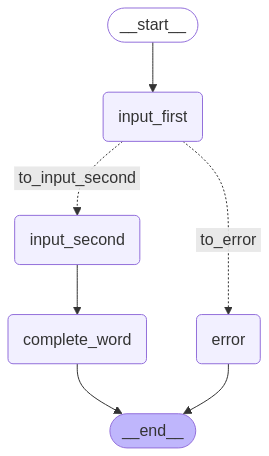

In [5]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [6]:
result = app.invoke({"init_input": "hello"})
print("Result:")
print(result)

start input_first()
continue_next: state: {'init_input': 'hello', 'first_word': 'hello'}
- continue to_input_second
start input_second()
start complete_word()
Result:
{'init_input': 'hello', 'first_word': 'hello', 'second_word': 'world', 'final_result': 'hello, world!'}


In [7]:
result = app.invoke({"init_input": "hey"})
print("Result:")
print(result)

start input_first()
continue_next: state: {'init_input': 'hey', 'first_word': 'error'}
- continue to_error
start error()
Result:
{'init_input': 'hey', 'first_word': 'error', 'second_word': 'error', 'final_result': 'error'}
